In [3]:
# CNN Architecture Experiments on Mini-ImageNet (Part-A)
# Kernel: Python (ml_torch)
# Dataset path: ../dataset
#Please train a network for image classification on mini-imagenet datasets (mentioned
#below). You should experiment with the following network parameters:
    #1. number of convolutional (conv) layers
    #2. fully connected (fc) layers
    #3. number of filters in different layers
    #4. Max Pooling
    #5. training time (number of epochs)
    #6. Stride


In [4]:

import os
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder


In [5]:

DATASET_ROOT = "../dataset"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
NUM_WORKERS = 2
LEARNING_RATE = 1e-3

train_tfms = transforms.Compose([
    transforms.Resize((84, 84)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

eval_tfms = transforms.Compose([
    transforms.Resize((84, 84)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_ds = ImageFolder(os.path.join(DATASET_ROOT, "train"), transform=train_tfms)
val_ds   = ImageFolder(os.path.join(DATASET_ROOT, "val"), transform=eval_tfms)
test_ds  = ImageFolder(os.path.join(DATASET_ROOT, "test"), transform=eval_tfms)

NUM_CLASSES = len(train_ds.classes)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print("Classes:", NUM_CLASSES)


Classes: 33


In [6]:

class ConfigurableCNN(nn.Module):
    def __init__(self, conv_filters, fc_layers, use_pool=True, stride=1, num_classes=None):
        super().__init__()
        layers = []
        in_channels = 3
        for f in conv_filters:
            layers.append(nn.Conv2d(in_channels, f, 3, stride=stride, padding=1))
            layers.append(nn.ReLU())
            if use_pool:
                layers.append(nn.MaxPool2d(2))
            in_channels = f
        self.features = nn.Sequential(*layers)

        with torch.no_grad():
            dummy = torch.zeros(1, 3, 84, 84)
            out = self.features(dummy)
            flat_dim = out.view(1, -1).size(1)

        fc = []
        in_dim = flat_dim
        for h in fc_layers:
            fc.append(nn.Linear(in_dim, h))
            fc.append(nn.ReLU())
            in_dim = h
        fc.append(nn.Linear(in_dim, num_classes))
        self.classifier = nn.Sequential(*fc)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)


In [7]:

def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)
    return correct / total

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)
    return correct / total


In [ ]:

# Part A : Experiment - Model  configurations.
experiments = [
    {"conv_filters": [32, 64], "fc_layers": [128], "use_pool": True, "stride": 1, "epochs": 10},
    {"conv_filters": [32, 64, 128], "fc_layers": [256, 128], "use_pool": True, "stride": 1, "epochs": 15},
    {"conv_filters": [32, 64], "fc_layers": [128], "use_pool": False, "stride": 2, "epochs": 10}
]

best_test_acc = 0.0
best_cfg = None

for cfg in experiments:
    # ---- Separate model config from training config ----
    model_cfg = {
        "conv_filters": cfg["conv_filters"],
        "fc_layers": cfg["fc_layers"],
        "use_pool": cfg["use_pool"],
        "stride": cfg["stride"]
    }

    model = ConfigurableCNN(**model_cfg, num_classes=NUM_CLASSES).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()

    # ---- Training loop ----
    for _ in range(cfg["epochs"]):
        train_one_epoch(model, train_loader, criterion, optimizer)

    test_acc = evaluate(model, test_loader)
    print("Config:", cfg, "Test Acc:", test_acc)

    # ---- Save best model ----
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_cfg = cfg
        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "config": model_cfg
            },
            "best_model_checkpoint.pth"
        )


Config: {'conv_filters': [32, 64], 'fc_layers': [128], 'use_pool': True, 'stride': 1, 'epochs': 10} Test Acc: 0.4166666666666667
Config: {'conv_filters': [32, 64, 128], 'fc_layers': [256, 128], 'use_pool': True, 'stride': 1, 'epochs': 15} Test Acc: 0.4445454545454545
Config: {'conv_filters': [32, 64], 'fc_layers': [128], 'use_pool': False, 'stride': 2, 'epochs': 10} Test Acc: 0.3381818181818182


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0007002..2.5528543].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.4482791].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.2042704].


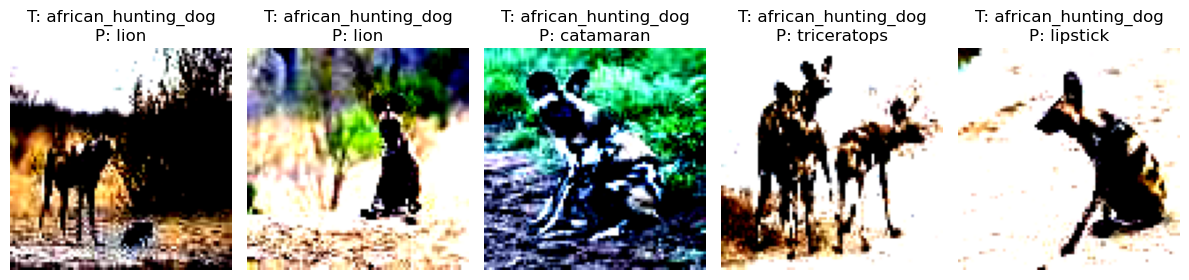

In [10]:
# Misclassification Analysis 

class_names = test_ds.classes
misclassified = []

model.eval()
with torch.no_grad():
    for img, label in test_ds:
        img = img.unsqueeze(0).to(DEVICE)
        output = model(img)
        pred = output.argmax(dim=1).item()

        if pred != label:
            misclassified.append((img.cpu().squeeze(), label, pred))
        
        if len(misclassified) == 5:
            break

# Plot misclassified images
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
for i, (img, true_label, pred_label) in enumerate(misclassified):
    plt.subplot(1, 5, i + 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f"T: {class_names[true_label]}\nP: {class_names[pred_label]}")
    plt.axis("off")

plt.tight_layout()
plt.show()
